In [1]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Iterative Soft Thresholding Algorithm (ISTA)

In [2]:
def softshrink(x, lambda_):
    return np.sign(x) * np.maximum(0, np.abs(x) - lambda_)

In [3]:
def ISTA(y, A, L, eps = 1e-4, max_iter = 3000):

    x = np.random.randn(A.shape[1])

    loss = np.linalg.norm(y - A @ x)**2 + L * np.linalg.norm(x, ord = 1)
    losses = [loss]
    iters = 0

    B = A.T @ y
    C = A.T @ A

    mu = np.real(1 /np.max(np.linalg.eigvals(C)))
    
    while loss > eps and iters < max_iter:

        x_hat = x - mu*(C @ x - B) 
        x = softshrink(x_hat, L * mu)

        # Decreasing step size
        #mu *= 0.99

        # Loss tracking
        loss = np.linalg.norm(y - A @ x)**2 + L * np.linalg.norm(x, ord = 1)
        losses.append(loss)

        iters += 1
        
    return x, losses

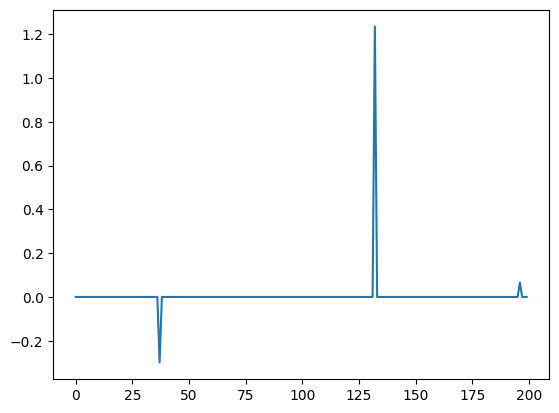

In [4]:
S = np.zeros(200)
S[np.random.choice(200, 3)] = np.random.normal(scale=0.5, size = 3)
plt.plot(S)

In [5]:
A = np.random.normal(size = (150,200))
A /= np.linalg.norm(A, axis = 0)

In [6]:
y = A @ S

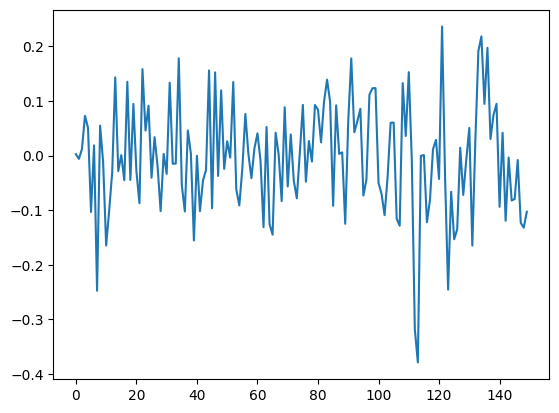

In [7]:
plt.plot(y)

In [8]:
x, losses = ISTA(y, A, 1e-1)

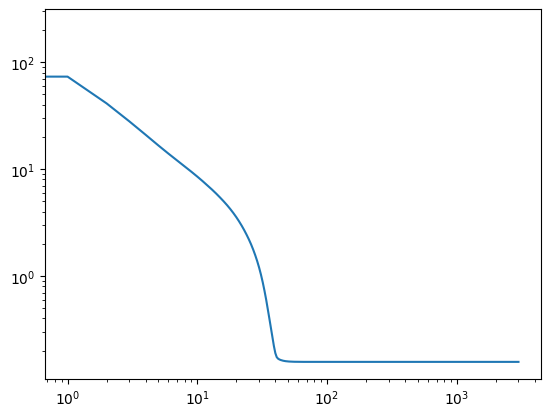

In [9]:
plt.loglog(losses)

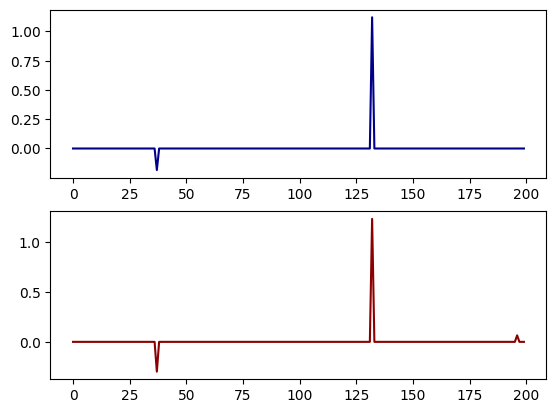

In [10]:
fig, axs = plt.subplots(2)

axs[0].plot(x, color='darkblue')
axs[1].plot(S, color='darkred')

plt.show()

# Learned Iterative Soft Thresholding Algorithm (LISTA)

In [52]:
class SyntheticSignals():
    def __init__(self, A, n, m, s, s_sigma = 0.5, eps_sigma = 0.01, size = 1000, batch_size = 512):
        
        self.n = n          # Number of samples in the original signal
        self.m = m          # Number of samples through the linear transformation

        self.size = size    # Size of the dataset

        self.x = torch.zeros(self.size,self.n)
        self.y = torch.zeros(self.size,self.m)

        self.A = A          # Matrix for the linear observation

        self.s = s          # Sparsity of the signal

        self.s_sigma = s_sigma
        self.eps_sigma = eps_sigma

        self.batch_size = batch_size

        # Generating the dataset
        self.set_data()


    def set_tuple(self, i):

        # Generating random sparsity in the canonic basis of the original signal
        idxs = np.random.choice(self.m, self.s, replace=False)
        peaks = np.random.normal(scale=self.s_sigma, size = self.s)

        # Generating the original signal and its corrupted observations
        self.x[i, idxs] = torch.from_numpy(peaks).to(self.x)
        self.y[i,:] = self.A @ self.x[i,:] + np.random.normal(scale=self.eps_sigma, size=self.m)


    def set_data(self):
        for i in range(self.size):
            self.set_tuple(i)
    
    
    def set_loader(self):
        return Data.DataLoader(dataset = Data.TensorDataset(self.y, self.x),
                               batch_size = self.batch_size,
                               shuffle = True)

In [53]:
# Dimensions for the signal, its sparsity and its observation

n_ = 200
m_ = 150
s_ = 4

# Measurement matrix
A_ = torch.randn(150,200)
A_ /= torch.norm(A_, dim=0)

# Building a training set and a test set 
train_set = SyntheticSignals(A = A_,
                             n = n_,
                             m = m_,
                             s = s_,
                             size = 800).set_loader()

test_set = SyntheticSignals(A = A_,
                             n = n_,
                             m = m_,
                             s = s_,
                             size = 200).set_loader()

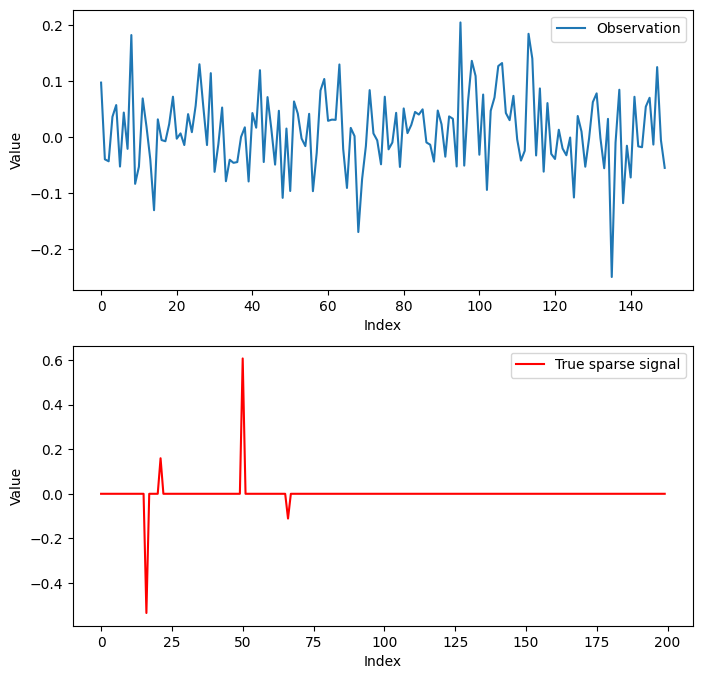

In [54]:
x_exm, s_exm =test_set.dataset.__getitem__(0)
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x_exm, label = 'Observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s_exm, label = 'True sparse signal', color='r')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend()
plt.show()

In [55]:
class LISTA_LAYER(nn.Module):
    def __init__(self, A):
        super().__init__()

        # Initialization of the learnable parameters

        self.W1 = nn.Linear(A.shape[0], A.shape[1], bias=False)
        self.W2 = nn.Linear(A.shape[1], A.shape[1], bias=False)

        self.beta = nn.Parameter(torch.ones(1, 1, 1), requires_grad=True)       
        
        self.W1.weight.data = A.t()
        self.W2.weight.data = A.t() @ A
        
    def _shrink(self, x, beta):
        return beta * F.softshrink(x / beta, lambd=1)
    
    def forward(self, y, x):       
        if x is None:
            x = torch.zeros(y.shape[0], A.shape[1])

        return self._shrink(self.W1(y) + self.W2(x), 
                            self.beta)

In [99]:
class LISTA_Net(nn.Module):
    def __init__(self, A, K = 5):
        super(LISTA_Net, self).__init__()

        # Number of layers <-> iterations
        self.K = K

        # Layers
        self.LISTA_layers = nn.ModuleList([LISTA_LAYER(A) for _ in range(self.K + 1)])

        # Losses when doing inference
        self.losses = []

    def forward(self, y, S = None):     

        x = self.LISTA_layers[0].forward(y,None)

        for i in range(1, self.K + 1):

            x = self.LISTA_layers[i].forward(y,x)

            if S is not None:
                self.losses.append(F.mse_loss(x.detach(), S.detach(), reduction="sum").data.item())
                
        return x

In [100]:
def train(model, train_loader, valid_loader, num_epochs=100):
    """Train a network.
    Returns:
        loss_test {numpy} -- loss function values on test set
    """
    
    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )
    
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=50, gamma=0.1
    )

    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    # Main loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for _, (Y, S) in enumerate(train_loader):
            x_hat = model.forward(Y)
            loss = F.mse_loss(x_hat, S, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # Validation
        model.eval()
        test_loss = 0
        for _, (Y, S) in enumerate(train_loader):
            x_hat = model.forward(Y)
            loss = F.mse_loss(x_hat, S, reduction="sum")
            optimizer.zero_grad()
            test_loss += F.mse_loss(x_hat, S, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)

        # Log progress
        if epoch % 10 == 0:
            print(
                "Epoch %d, Train loss %.8f, Validation loss %.8f"
                % (epoch, loss_train[epoch], loss_test[epoch])
            )

    return loss_test

In [101]:
model = LISTA_Net(A_, 5)

In [102]:
loss = train(model, train_set, test_set)

Epoch 0, Train loss 0.81732372, Validation loss 3.16637955
Epoch 10, Train loss 0.60210140, Validation loss 2.31780434
Epoch 20, Train loss 0.13908715, Validation loss 0.56667618
Epoch 30, Train loss 0.10792320, Validation loss 0.41239637
Epoch 40, Train loss 0.09781890, Validation loss 0.38882782
Epoch 50, Train loss 0.09233788, Validation loss 0.36918755
Epoch 60, Train loss 0.09184262, Validation loss 0.36721548
Epoch 70, Train loss 0.09139672, Validation loss 0.36543289
Epoch 80, Train loss 0.09095906, Validation loss 0.36369135
Epoch 90, Train loss 0.09053024, Validation loss 0.36198032


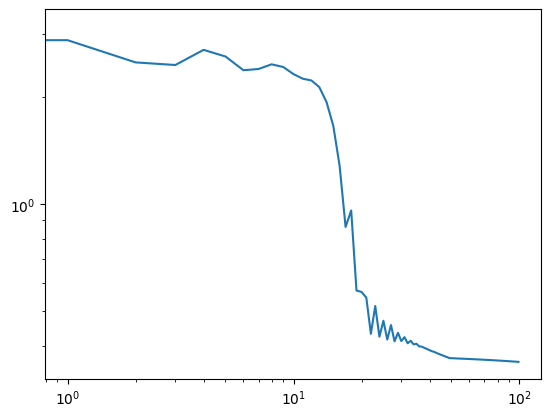

In [103]:
plt.loglog(loss)

### Comparing ISTA and LISTA

In [128]:
def ISTA_torch(y, A, S, rho=0.5, L=1, max_itr=300):

    loss = np.zeros(max_itr)
    x_hat = torch.zeros(A.shape[1])
    proj = torch.nn.Softshrink(lambd= rho / L)

    for idx in range(max_itr):
        x_tilde = x_hat - 1 / L * (A.T @ (A @ x_hat - y))
        x_hat = proj(x_tilde)

        # Loss tracking
        loss[idx] = F.mse_loss(x_hat, S, reduction="sum").data.item()

    return loss

In [129]:
def ISTA_BATCH(test_loader, T, A, rho=1):
    A = A.cpu()
    m = A.shape[1]
    L = float(scipy.linalg.eigvalsh(A.t() @ A, eigvals=(m - 1, m - 1)))

    # Aggregate T iterations' MSE loss
    losses = np.zeros((len(test_loader.dataset), T))
    for idx, (y, S) in enumerate(test_loader.dataset):
        losses[idx, :] = ISTA_torch(y=y, A=A, S=S, L=L, max_itr=T)

    return losses.mean(axis=0)

In [130]:
def LISTA_INFERENCE(lista_model, test_loader):
    for _, (Y, S) in enumerate(test_loader):
        x_hat = lista_model.forward(Y, S)
    L = lista_model.losses
    lista_model.losses = []

    return np.array(L)/len(test_loader.dataset)

In [131]:
ista_loss = ISTA_BATCH(test_set, 100, A_)
lista_loss = LISTA_INFERENCE(model, test_set)

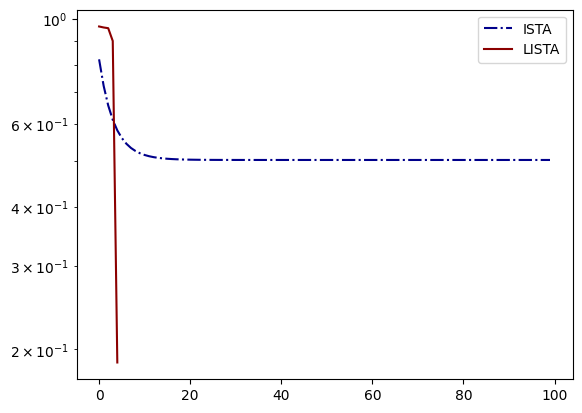

In [140]:
plt.plot(ista_loss, label = 'ISTA', color ='darkblue', linestyle = 'dashdot')
plt.plot(lista_loss, label = 'LISTA', color = 'darkred')
plt.legend()
plt.yscale('log')